# Credit Card Default
August 15, 2019<br>Ngoc, Modeling Transformed Data

-----------------------------------------------------------------

In this notebook, we will perform modeling for transformed data.

----------------------------------------------

# Import

In [65]:
%matplotlib inline

import os
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.svm import SVC
from datetime import datetime
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.classifier import ConfusionMatrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_curve, roc_auc_score

sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

Change directory to get data source code:

In [2]:
main_path = os.getcwd()
parent_path = Path(os.getcwd()).parent
src_path = str(parent_path) + "/src/directories"
os.chdir(src_path)

More import:

In [3]:
import change_directory

Change back to notebook directory:

In [4]:
os.chdir(main_path)

Change directory to get helper functions:

In [5]:
cd = change_directory.ChangeDirectory()

In [6]:
cd.change_to_src_models_dir()

More import:

In [7]:
import evaluation_functions
all_scores = evaluation_functions.all_scores
scores_confusion_matrix = evaluation_functions.scores_confusion_matrix

Change back to notebook directory:

In [8]:
cd.change_to_notebook_dir()

# ETL

## Load data

Change directory to get data:

In [9]:
cd.change_to_data_dir()

Load data:

In [10]:
ccd_df = pd.read_csv("processed/transformed_credit_card_default.csv")

Change back to notebook directory:

In [11]:
cd.change_to_notebook_dir()

## Sample data
Methods to tackle imbalance: over-sampling, under-sampling, and SMOTE.

In [12]:
ccd_df.drop("Unnamed: 0", axis=1, inplace=True)

In [13]:
ccd_ns = ccd_df.copy()
ccd_ou = ccd_df.copy()
ccd_smote = ccd_df.copy()

### Over-sampling

In [14]:
default_samples = ccd_ou[ccd_ou.DEFAULT == 1]
non_default_samples = ccd_ou[ccd_ou.DEFAULT == 0]

In [15]:
default_samples_train, default_samples_test = train_test_split(default_samples,
                                                               test_size=0.2,
                                                               random_state=111)
non_default_samples_train, non_default_samples_test = train_test_split(non_default_samples,
                                                                       test_size=0.2,
                                                                       random_state=111)

In [16]:
np.random.seed(42)
os_default_idx = np.random.choice(default_samples_train.index,
                                  size=non_default_samples_train.shape[0], replace=True)
os_default = default_samples_train.loc[os_default_idx, :]

In [17]:
ccd_over_sampled_train = pd.concat([os_default, non_default_samples_train], axis=0)
X_over_sampled_train = ccd_over_sampled_train.drop("DEFAULT", axis=1)
y_over_sampled_train = ccd_over_sampled_train.DEFAULT

ccd_over_sampled_test = pd.concat([default_samples_test, non_default_samples_test], axis=0)
X_over_sampled_test = ccd_over_sampled_test.drop("DEFAULT", axis=1)
y_over_sampled_test = ccd_over_sampled_test.DEFAULT

### Under-sampling

In [18]:
np.random.seed(42)
us_non_default_idx = np.random.choice(non_default_samples.index, size=default_samples.shape[0], replace=False)
us_non_default = non_default_samples.loc[us_non_default_idx, :]

In [19]:
ccd_under_sampled = pd.concat([us_non_default, default_samples], axis=0)
X_under_sampled = ccd_under_sampled.drop("DEFAULT", axis=1)
y_under_sampled = ccd_under_sampled.DEFAULT
X_under_sampled_train, X_under_sampled_test, y_under_sampled_train, y_under_sampled_test = train_test_split(X_under_sampled, y_under_sampled, test_size=0.2, random_state=111)

### SMOTE

In [20]:
X_smote = ccd_smote.drop("DEFAULT", axis=1)
y_smote = ccd_smote.DEFAULT
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote,
                                                                            test_size=0.2, random_state=111)
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_smote_train, y_smote_train)

## Data for modeling

In [21]:
# non-sampled
X_non_sampled = ccd_ns.drop("DEFAULT", axis=1)
y_non_sampled = ccd_ns.DEFAULT
non_sampled_X_train, non_sampled_X_test, non_sampled_y_train, non_sampled_y_test = train_test_split(X_non_sampled,
                                                                                                    y_non_sampled,
                                                                                                    test_size=0.2,
                                                                                                    random_state=111)

In [22]:
# over-sampled
over_sampled_X_train = X_over_sampled_train
over_sampled_y_train = y_over_sampled_train
over_sampled_X_test = X_over_sampled_test
over_sampled_y_test = y_over_sampled_test

In [23]:
# under-sampled
under_sampled_X_train = X_under_sampled_train
under_sampled_y_train = y_under_sampled_train
under_sampled_X_test = X_under_sampled_test
under_sampled_y_test = y_under_sampled_test

In [24]:
# SMOTE
smote_sampled_X_train = X_sm
smote_sampled_y_train = y_sm
smote_sampled_X_test = X_smote_test
smote_sampled_y_test = y_smote_test

# Model

## Non-sampled

### Logistic Regression

In [25]:
ns_lr = LogisticRegression()
param_grid = {"penalty": ["l1", "l2"],
              "C": [0.01, 0.1, 1, 10],
              "class_weight": ["balanced", None],
              "random_state": [42],
              "solver": ["liblinear"], 
              "n_jobs": [-1]}
ns_lr_gs = GridSearchCV(ns_lr, param_grid, cv=3, scoring="recall", n_jobs=-1)
ns_lr_gs.fit(non_sampled_X_train, non_sampled_y_train);
ns_lr_gs.best_params_

{'C': 10,
 'class_weight': 'balanced',
 'n_jobs': -1,
 'penalty': 'l1',
 'random_state': 42,
 'solver': 'liblinear'}

Evaluate the best logistic model:

Training Scores:
f-1 score: 0.5430930810550789
recall: 0.6342696629213483
precision:0.4748352726762933
Test Scores:
f-1 score: 0.5164319248826291
recall: 0.5941358024691358
precision:0.45670225385527874


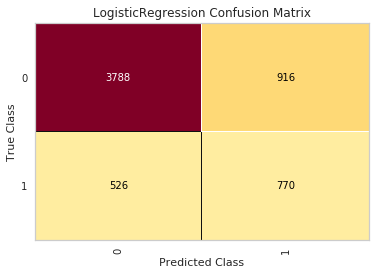

In [26]:
scores_confusion_matrix(ns_lr_gs, non_sampled_X_train, non_sampled_X_test,
                        non_sampled_y_train, non_sampled_y_test)

### Decision Tree

In [27]:
ns_dt = DecisionTreeClassifier()
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [None, 8, 10],
              "min_samples_split": [10, 25],
              "min_samples_leaf": [1, 5],
              "max_features": [None, "sqrt"],
              "class_weight": ["balanced", None],
              "random_state": [42]}
ns_dt_gs = GridSearchCV(ns_dt, param_grid, cv=3, scoring="recall", n_jobs=-1)
ns_dt_gs.fit(non_sampled_X_train, non_sampled_y_train);
ns_dt_gs.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 25,
 'random_state': 42}

Evaluate the best decision tree model:

Training Scores:
f-1 score: 0.5354296478771193
recall: 0.6919475655430711
precision:0.4366580004727015
Test Scores:
f-1 score: 0.48752969121140144
recall: 0.6334876543209876
precision:0.39623552123552125


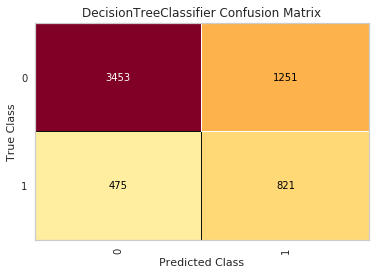

In [28]:
scores_confusion_matrix(ns_dt_gs, non_sampled_X_train, non_sampled_X_test,
                        non_sampled_y_train, non_sampled_y_test)

### Random Forest

In [29]:
ns_rf = RandomForestClassifier()
param_grid = {"n_estimators": [50, 100],
              "criterion": ["gini", "entropy"],
              "max_depth": [None, 10],
              "min_samples_split": [10, 25],
              "min_samples_leaf": [1, 5],
              "max_features": [None, "sqrt"],
              "class_weight": ["balanced", None],
              "random_state": [42],
              "n_jobs": [-1]}
ns_rf_gs = GridSearchCV(ns_rf, param_grid, cv=3, scoring="recall", n_jobs=-1)
ns_rf_gs.fit(non_sampled_X_train, non_sampled_y_train);
ns_rf_gs.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 25,
 'n_estimators': 100,
 'n_jobs': -1,
 'random_state': 42}

Evaluate the best random forest model:

Training Scores:
f-1 score: 0.5889934707029594
recall: 0.650374531835206
precision:0.538199287153262
Test Scores:
f-1 score: 0.5281173594132028
recall: 0.5833333333333334
precision:0.4824505424377792


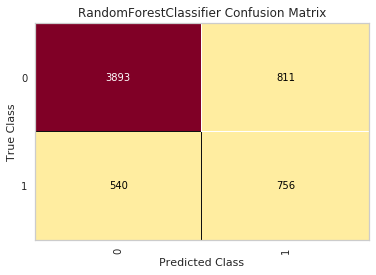

In [30]:
scores_confusion_matrix(ns_rf_gs, non_sampled_X_train, non_sampled_X_test,
                        non_sampled_y_train, non_sampled_y_test)

## Over-sampled

### Logistic Regression

In [35]:
os_lr = LogisticRegression()
param_grid = {"penalty": ["l1", "l2"],
              "C": [0.01, 0.1, 1, 10],
              "class_weight": ["balanced", None],
              "random_state": [42],
              "solver": ["liblinear"], 
              "n_jobs": [-1]}
os_lr_gs = GridSearchCV(os_lr, param_grid, cv=3, scoring="recall", n_jobs=-1)
os_lr_gs.fit(over_sampled_X_train, over_sampled_y_train);
os_lr_gs.best_params_

{'C': 10,
 'class_weight': 'balanced',
 'n_jobs': -1,
 'penalty': 'l1',
 'random_state': 42,
 'solver': 'liblinear'}

Evaluate the best logistic model:

Training Scores:
f-1 score: 0.6824405547248366
recall: 0.622652613557327
precision:0.7549299429164504
Test Scores:
f-1 score: 0.5532612258275976
recall: 0.6355421686746988
precision:0.48984329657574


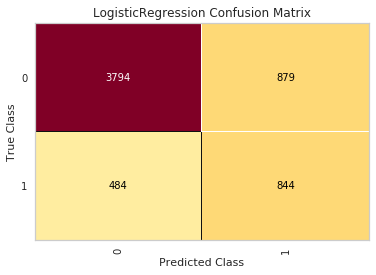

In [36]:
scores_confusion_matrix(os_lr_gs, over_sampled_X_train, over_sampled_X_test,
                        over_sampled_y_train, over_sampled_y_test)

### Decision Tree

In [37]:
os_dt = DecisionTreeClassifier()
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [None, 8, 10],
              "min_samples_split": [10, 25],
              "min_samples_leaf": [1, 5],
              "max_features": [None, "sqrt"],
              "class_weight": ["balanced", None],
              "random_state": [42]}
os_dt_gs = GridSearchCV(os_dt, param_grid, cv=3, scoring="recall", n_jobs=-1)
os_dt_gs.fit(over_sampled_X_train, over_sampled_y_train);
os_dt_gs.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'random_state': 42}

Evaluate the best decision tree model:

Training Scores:
f-1 score: 0.9779321399946567
recall: 0.9791878444170992
precision:0.9766796520625434
Test Scores:
f-1 score: 0.41006661732050337
recall: 0.4171686746987952
precision:0.4032023289665211


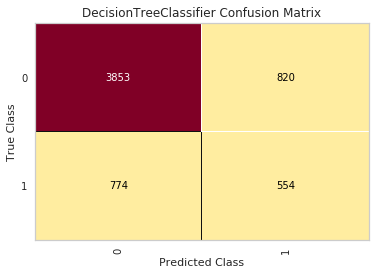

In [38]:
scores_confusion_matrix(os_dt_gs, over_sampled_X_train, over_sampled_X_test,
                        over_sampled_y_train, over_sampled_y_test)

### Random Forest

In [39]:
os_rf = RandomForestClassifier()
param_grid = {"n_estimators": [50, 100],
              "criterion": ["gini", "entropy"],
              "max_depth": [None, 10],
              "min_samples_split": [10, 25],
              "min_samples_leaf": [1, 5],
              "max_features": [None, "sqrt"],
              "class_weight": ["balanced", None],
              "random_state": [42],
              "n_jobs": [-1]}
os_rf_gs = GridSearchCV(os_rf, param_grid, cv=3, scoring="recall", n_jobs=-1)
os_rf_gs.fit(over_sampled_X_train, over_sampled_y_train);
os_rf_gs.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 50,
 'n_jobs': -1,
 'random_state': 42}

Evaluate the best random forest model:

Training Scores:
f-1 score: 0.9949493599850351
recall: 0.9959873736022685
precision:0.993913507741591
Test Scores:
f-1 score: 0.506825938566553
recall: 0.44728915662650603
precision:0.5846456692913385


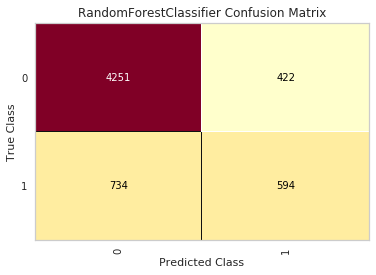

In [40]:
scores_confusion_matrix(os_rf_gs, over_sampled_X_train, over_sampled_X_test,
                        over_sampled_y_train, over_sampled_y_test)

## Under-sampled

### Logistic Regression

In [45]:
us_lr = LogisticRegression()
param_grid = {"penalty": ["l1", "l2"],
              "C": [0.01, 0.1, 1, 10],
              "class_weight": ["balanced", None],
              "random_state": [42],
              "solver": ["liblinear"], 
              "n_jobs": [-1]}
us_lr_gs = GridSearchCV(us_lr, param_grid, cv=3, scoring="recall", n_jobs=-1)
us_lr_gs.fit(under_sampled_X_train, under_sampled_y_train);
us_lr_gs.best_params_

{'C': 10,
 'class_weight': 'balanced',
 'n_jobs': -1,
 'penalty': 'l1',
 'random_state': 42,
 'solver': 'liblinear'}

Evaluate the best logistic model:

Training Scores:
f-1 score: 0.6797167846730529
recall: 0.6174801362088536
precision:0.7559055118110236
Test Scores:
f-1 score: 0.6934097421203439
recall: 0.6274074074074074
precision:0.7749313815187557


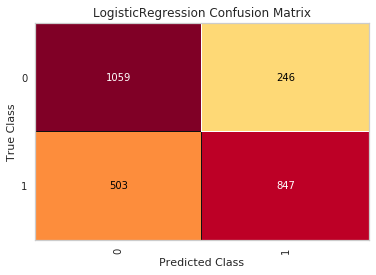

In [46]:
scores_confusion_matrix(us_lr_gs, under_sampled_X_train, under_sampled_X_test,
                        under_sampled_y_train, under_sampled_y_test)

### Decision Tree

In [47]:
us_dt = DecisionTreeClassifier()
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [None, 8, 10],
              "min_samples_split": [10, 25],
              "min_samples_leaf": [1, 5],
              "max_features": [None, "sqrt"],
              "class_weight": ["balanced", None],
              "random_state": [42]}
us_dt_gs = GridSearchCV(us_dt, param_grid, cv=3, scoring="recall", n_jobs=-1)
us_dt_gs.fit(under_sampled_X_train, under_sampled_y_train);
us_dt_gs.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'random_state': 42}

Evaluate the best decision tree model:

Training Scores:
f-1 score: 0.8050116009280742
recall: 0.8204691638289822
precision:0.7901257059573693
Test Scores:
f-1 score: 0.6741248646697943
recall: 0.6918518518518518
precision:0.657283603096411


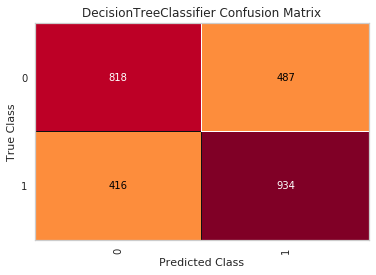

In [48]:
scores_confusion_matrix(us_dt_gs, under_sampled_X_train, under_sampled_X_test,
                        under_sampled_y_train, under_sampled_y_test)

### Random Forest

In [49]:
us_rf = RandomForestClassifier()
param_grid = {"n_estimators": [50, 100],
              "criterion": ["gini", "entropy"],
              "max_depth": [None, 10],
              "min_samples_split": [10, 25],
              "min_samples_leaf": [1, 5],
              "max_features": [None, "sqrt"],
              "class_weight": ["balanced", None],
              "random_state": [42],
              "n_jobs": [-1]}
us_rf_gs = GridSearchCV(us_rf, param_grid, cv=3, scoring="recall", n_jobs=-1)
us_rf_gs.fit(under_sampled_X_train, under_sampled_y_train);
us_rf_gs.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 50,
 'n_jobs': -1,
 'random_state': 42}

Evaluate the best random forest model:

Training Scores:
f-1 score: 0.9232518476407049
recall: 0.9216799091940976
precision:0.9248291571753986
Test Scores:
f-1 score: 0.691764705882353
recall: 0.6533333333333333
precision:0.735


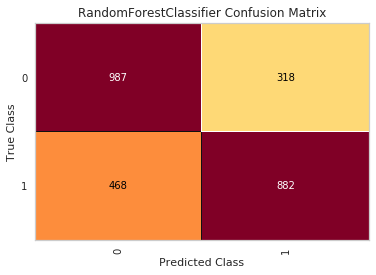

In [50]:
scores_confusion_matrix(us_rf_gs, under_sampled_X_train, under_sampled_X_test,
                        under_sampled_y_train, under_sampled_y_test)

## SMOTE-sampled

### Logistic Regression

In [55]:
sm_lr = LogisticRegression()
param_grid = {"penalty": ["l1", "l2"],
              "C": [0.01, 0.1, 1, 10],
              "class_weight": ["balanced", None],
              "random_state": [42],
              "solver": ["liblinear"], 
              "n_jobs": [-1]}
sm_lr_gs = GridSearchCV(sm_lr, param_grid, cv=3, scoring="recall", n_jobs=-1)
sm_lr_gs.fit(smote_sampled_X_train, smote_sampled_y_train);
sm_lr_gs.best_params_

{'C': 10,
 'class_weight': 'balanced',
 'n_jobs': -1,
 'penalty': 'l1',
 'random_state': 42,
 'solver': 'liblinear'}

Evaluate the best logistic model:

Training Scores:
f-1 score: 0.6886940363509669
recall: 0.6355841371918542
precision:0.7514890381447218
Test Scores:
f-1 score: 0.5175237471339666
recall: 0.6095679012345679
precision:0.4496300512236767


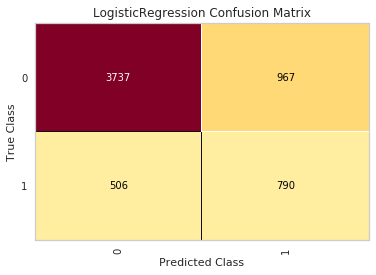

In [56]:
scores_confusion_matrix(sm_lr_gs, smote_sampled_X_train, smote_sampled_X_test,
                        smote_sampled_y_train, smote_sampled_y_test)

### Decision Tree

In [57]:
sm_dt = DecisionTreeClassifier()
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [None, 8, 10],
              "min_samples_split": [10, 25],
              "min_samples_leaf": [1, 5],
              "max_features": [None, "sqrt"],
              "class_weight": ["balanced", None],
              "random_state": [42]}
sm_dt_gs = GridSearchCV(sm_dt, param_grid, cv=3, scoring="recall", n_jobs=-1)
sm_dt_gs.fit(smote_sampled_X_train, smote_sampled_y_train);
sm_dt_gs.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'random_state': 42}

Evaluate the best decision tree model:

Training Scores:
f-1 score: 0.9486601688703065
recall: 0.9362808145766345
precision:0.9613712650635559
Test Scores:
f-1 score: 0.3954293628808864
recall: 0.44058641975308643
precision:0.3586683417085427


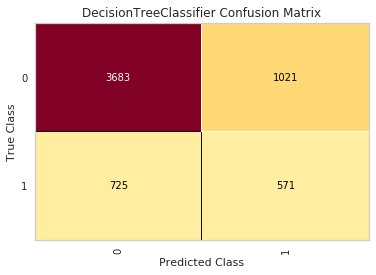

In [58]:
scores_confusion_matrix(sm_dt_gs, smote_sampled_X_train, smote_sampled_X_test,
                        smote_sampled_y_train, smote_sampled_y_test)

### Random Forest

In [59]:
sm_rf = RandomForestClassifier()
param_grid = {"n_estimators": [50, 100],
              "criterion": ["gini", "entropy"],
              "max_depth": [None, 10],
              "min_samples_split": [10, 25],
              "min_samples_leaf": [1, 5],
              "max_features": [None, "sqrt"],
              "class_weight": ["balanced", None],
              "random_state": [42],
              "n_jobs": [-1]}
sm_rf_gs = GridSearchCV(sm_rf, param_grid, cv=3, scoring="recall", n_jobs=-1)
sm_rf_gs.fit(smote_sampled_X_train, smote_sampled_y_train);
sm_rf_gs.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100,
 'n_jobs': -1,
 'random_state': 42}

Evaluate the best random forest model:

Training Scores:
f-1 score: 0.9741236728378595
recall: 0.9784565916398714
precision:0.9698289599490066
Test Scores:
f-1 score: 0.5140186915887851
recall: 0.5092592592592593
precision:0.5188679245283019


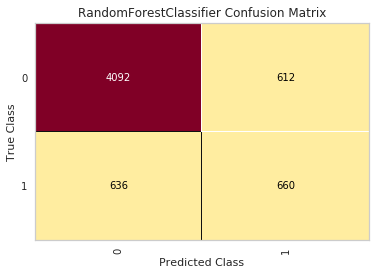

In [60]:
scores_confusion_matrix(sm_rf_gs, smote_sampled_X_train, smote_sampled_X_test,
                        smote_sampled_y_train, smote_sampled_y_test)

# Save best models

Change directory to save models:

In [70]:
cd.change_to_model_dir()

Save models:

In [71]:
with open("transformed_non_sampled_logistic_regression.pickle", "wb") as f:
    pickle.dump(ns_lr_gs, f)
    
with open("transformed_non_sampled_decision_tree.pickle", "wb") as f:
    pickle.dump(ns_dt_gs, f)
    
with open("transformed_non_sampled_random_forest.pickle", "wb") as f:
    pickle.dump(ns_rf_gs, f)
    
with open("transformed_over_sampled_logistic_regression.pickle", "wb") as f:
    pickle.dump(os_lr_gs, f)
    
with open("transformed_over_sampled_decision_tree.pickle", "wb") as f:
    pickle.dump(os_dt_gs, f)
    
with open("transformed_over_sampled_random_forest.pickle", "wb") as f:
    pickle.dump(os_rf_gs, f)
    
with open("transformed_under_sampled_logistic_regression.pickle", "wb") as f:
    pickle.dump(us_lr_gs, f)
    
with open("transformed_under_sampled_decision_tree.pickle", "wb") as f:
    pickle.dump(us_dt_gs, f)
    
with open("transformed_under_sampled_random_forest.pickle", "wb") as f:
    pickle.dump(us_rf_gs, f)
    
with open("transformed_smote_sampled_logistic_regression.pickle", "wb") as f:
    pickle.dump(sm_lr_gs, f)
    
with open("transformed_smote_sampled_decision_tree.pickle", "wb") as f:
    pickle.dump(sm_dt_gs, f)
    
with open("transformed_smote_sampled_random_forest.pickle", "wb") as f:
    pickle.dump(sm_rf_gs, f)

Change back to notebook directory:

In [72]:
cd.change_to_notebook_dir()